/tmp/ipython-input-3361057701.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('15T').interpolate()


,Energy_Capture,Temperature,Rainfall,Cloud_Cover_Ratio,Length_of_Daylight
count,210333.000000,210333.000000,210333.000000,210333.000000,210333.000000
mean,197.461863,25.345682,2.097267,45.474258,0.541674
std,270.187262,9.297718,9.398935,39.178468,0.498261
min,0.000000,0.470000,0.000000,0.000000,0.000000
25%,0.000000,18.395000,0.000000,4.630000,0.000000
50%,14.575000,26.500000,0.000000,37.820000,1.000000
75%,378.447500,31.987500,0.042500,89.510000,1.000000
max,1025.470000,48.140000,271.750000,100.000000,1.000000


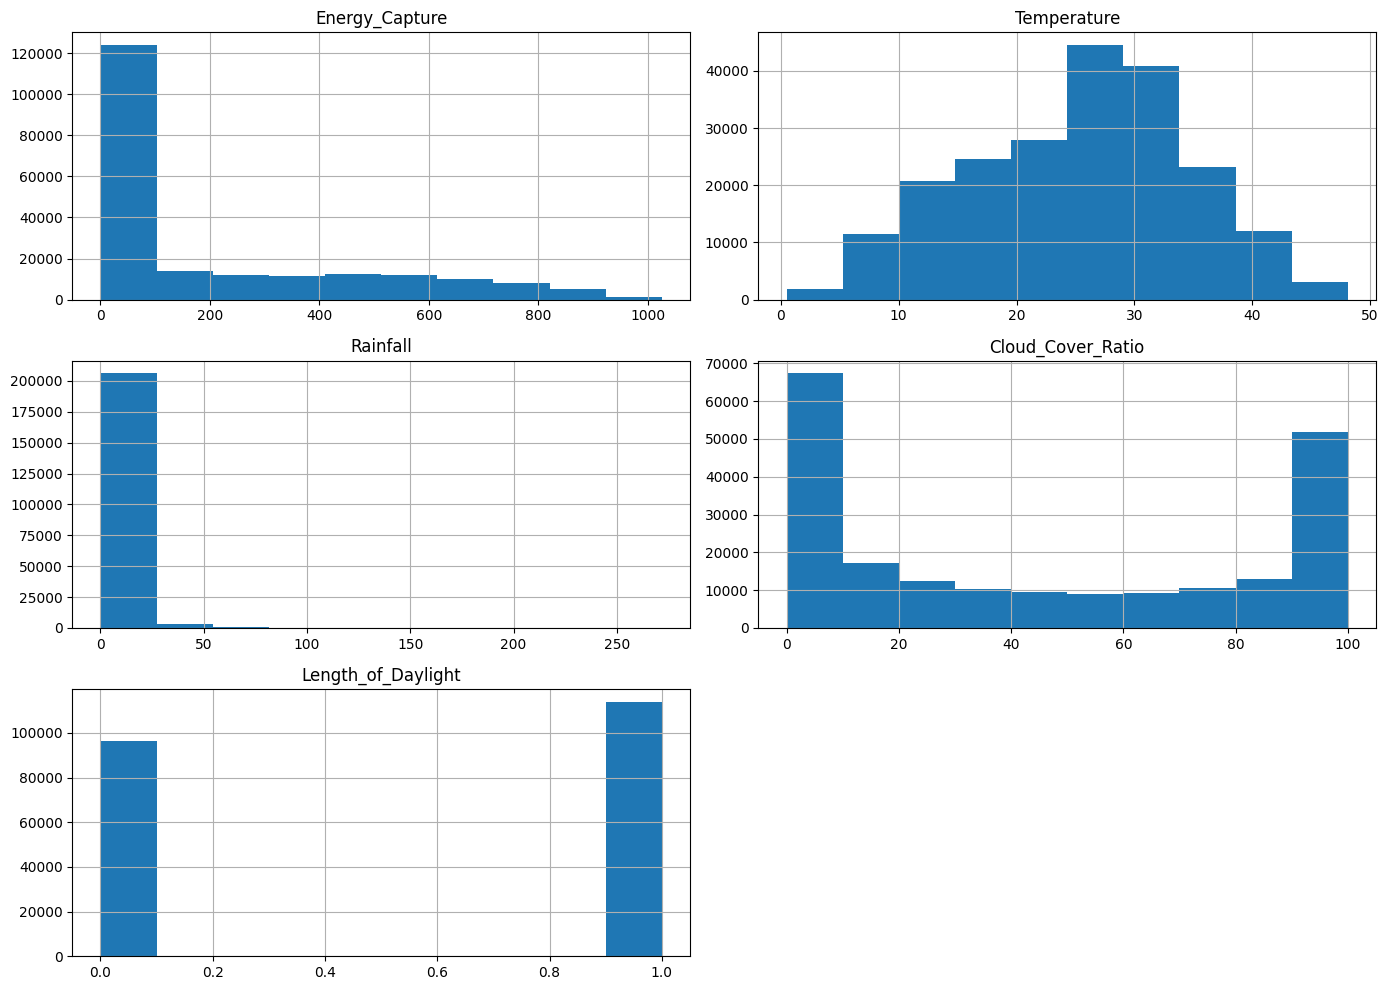

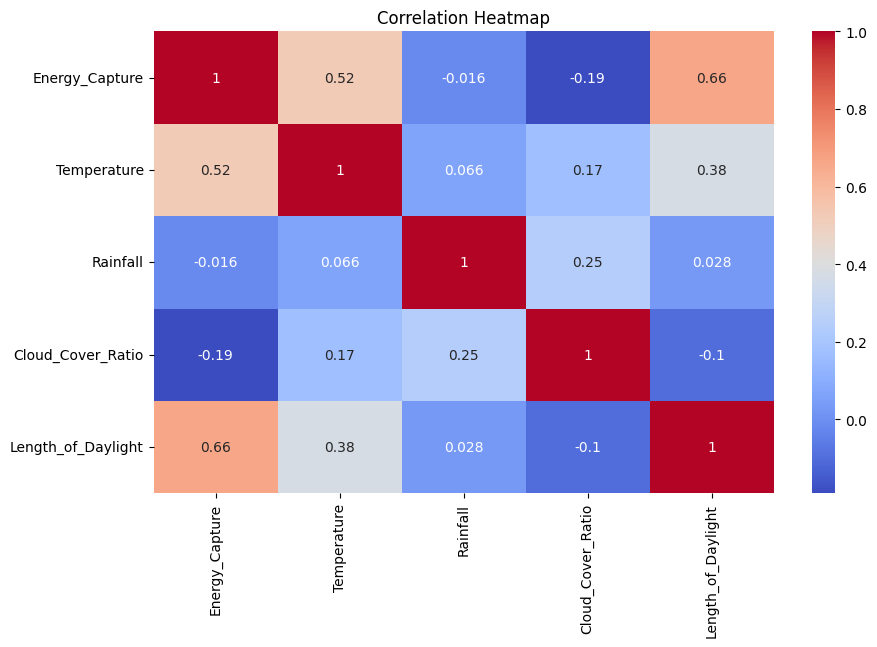

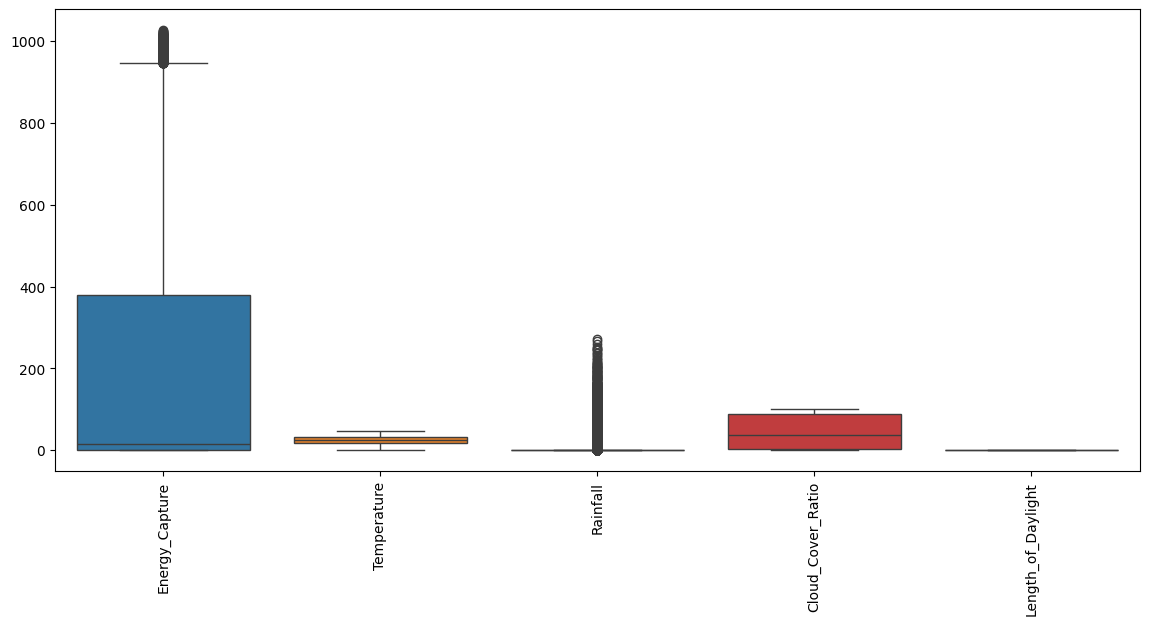

Linear Regression R2: 0.5423605687098638
Linear Regression MAE: 142.76600640220818
Linear Regression MSE: 32609.94613514142
Random Forest R2: 0.5625173654143267
Random Forest MAE: 106.91093618371558
Random Forest MSE: 31173.63621548154


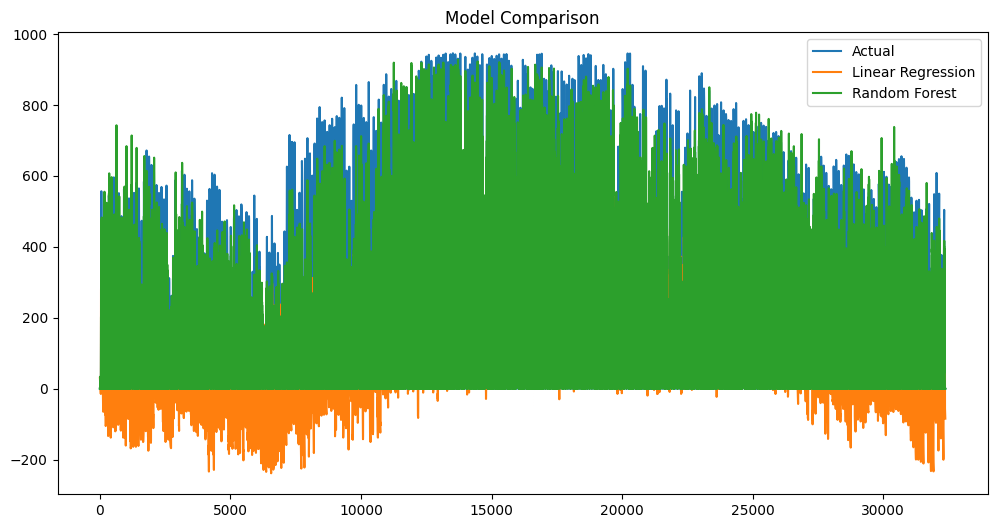

Average Energy Production (Jan 2026): 116.52932753008628


,timestamp,Average Energy (Wh)
0,2017,136.002373
1,2018,143.305892
2,2019,133.689479
3,2020,129.601457
4,2021,117.419199
5,2022,114.394875
6,2026,116.529328


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Download NASA POWER data (JSON)
url = (
    "https://power.larc.nasa.gov/api/temporal/hourly/point?"
    "parameters=ALLSKY_SFC_SW_DWN,T2M,PRECTOTCORR,CLOUD_AMT&"
    "community=RE&longitude=77.21&latitude=28.61&"
    "start=20170101&end=20221231&format=JSON"
)

data = requests.get(url).json()
records = data['properties']['parameter']

# Convert JSON to DataFrame
df = pd.DataFrame(records)
df.index = pd.to_datetime(df.index, format='%Y%m%d%H')
df.index.name = 'timestamp'

# Rename columns
df.rename(columns={
    'ALLSKY_SFC_SW_DWN': 'Energy_Capture',
    'T2M': 'Temperature',
    'PRECTOTCORR': 'Rainfall',
    'CLOUD_AMT': 'Cloud_Cover_Ratio'
}, inplace=True)

# Resample to 15-minute intervals
df = df.resample('15T').interpolate()

# Derive daylight length feature
df['Length_of_Daylight'] = ((df.index.hour >= 6) & (df.index.hour <= 18)).astype(int)

# Descriptive statistics
df.describe()
display(df.describe())

# Frequency distribution
df.hist(figsize=(14,10))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Handle missing values
df.fillna(df.median(), inplace=True)

# Outlier detection
plt.figure(figsize=(14,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

# Outlier removal (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature and target selection
X = df.drop('Energy_Capture', axis=1)
y = df['Energy_Capture']

# Train-test split (time-series aware)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, lr_pred))
print("Linear Regression MAE:", mean_absolute_error(y_test, lr_pred))
print("Linear Regression MSE:", mean_squared_error(y_test, lr_pred))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, rf_pred))
print("Random Forest MAE:", mean_absolute_error(y_test, rf_pred))
print("Random Forest MSE:", mean_squared_error(y_test, rf_pred))

# Model comparison plot
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual')
plt.plot(lr_pred, label='Linear Regression')
plt.plot(rf_pred, label='Random Forest')
plt.legend()
plt.title("Model Comparison")
plt.show()

# January 2026 forecast
jan_df = df[df.index.month == 1]
jan_features = jan_df.drop('Energy_Capture', axis=1)
jan_2026_avg = rf.predict(jan_features).mean()

print("Average Energy Production (Jan 2026):", jan_2026_avg)

# Historical comparison table
jan_history = jan_df.groupby(jan_df.index.year)['Energy_Capture'].mean()

comparison = jan_history.loc[2017:2022].to_frame()
comparison.loc[2026] = jan_2026_avg
comparison.columns = ['Average Energy (Wh)']

styled_table = (
    comparison.reset_index()
    .rename(columns={'index': 'Year'})
    .style
    .set_caption("Average Energy Production Comparison (January)")
    .background_gradient(cmap='YlGnBu', subset=['Average Energy (Wh)'])
    .set_properties(**{
        'text-align': 'center',
        'border': '1px solid black'
    })
    .set_table_styles([
        {'selector': 'th',
         'props': [
             ('background-color', '#2F5597'),
             ('color', 'white'),
             ('font-weight', 'bold'),
             ('text-align', 'center')
         ]},
        {'selector': 'caption',
         'props': [
             ('font-size', '16px'),
             ('font-weight', 'bold'),
             ('margin-bottom', '10px')
         ]}
    ])
)

styled_table
